##### Copyright 2018 Google LLC.


Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

This colab contains TensorFlow code for implementing the constrained optimization methods presented in the paper:
> Harikrishna Narasimhan, Andrew Cotter, Maya Gupta, Serena Wang, "Pairwise Fairness for Ranking and Regression", AAAI 2020. [<a href="https://arxiv.org/pdf/1906.05330.pdf">link</a>]

First, let's install and import the relevant libraries.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

We will need the TensorFlow Constrained Optimization (TFCO) library.

In [0]:
!pip install git+https://github.com/google-research/tensorflow_constrained_optimization

In [0]:
import tensorflow_constrained_optimization as tfco

## Constrained Optimization Problem

We will be training a linear ranking model $f(x) = w^\top x$ where $x \in \mathbb{R}^d$ is a set of features for a query-document pair (the protected attribute is not a feature). Our goal is to train the model such that it accurately ranks the positive documents in a query above the negative ones.


Specifically, for the ranking model $f$, we denote:
- $err(f)$ as the pairwise ranking error for model $f$ over all pairs of positive and negative documents
$$
err(f) = \mathbf{E}\big[\mathbb{I}\big(f(x) < f(x')\big) \,\big|\, y = 1,~ y' = 0\big]
$$


- $err_{i,j}(f)$ as the pairwise ranking error over positive-negative document pairs where the pos. document is from group $i$, and the neg. document is from group $j$.

$$
err_{i, j}(f) = \mathbf{E}\big[\mathbb{I}\big(f(x) < f(x')\big) \,\big|\, y = 1,~ y' = 0,~ grp(x) = i, ~grp(x') = j\big]
$$
<br>

We then wish to solve the following constrained problem:
$$min_f\; err(f)$$
$$\text{   s.t.   } |err_{i,j}(f) - err_{k,\ell}(f)| \leq \epsilon \;\;\; \forall ((i,j), (k,\ell)) \in \mathcal{G},$$

where $\mathcal{G}$ contains the pairs we are interested in constraining.

## Generate 2D Synthetic Data
 
We begin by generating a synthetic ranking dataset.

**Setting**:
- Set of $m$ queries, a set of  $n$ documents associated with each query.
- One document per query has a positive label, while the remaining have negative labels. 
- Each document is  associated with one of two protected groups.


**Generative process**:  

For convenience, the first document for each query is labeled positive, and remaining $n-1$ documents are labeled negative.

For each query-document pair:
 - Draw the protected group for the document from a $Bernoulli(\pi)$ distribution
 - Draw the document features from the following 2D Gaussian distributions:
  - $\mathcal{N}(\mu_{0,0}, \Sigma_{0,0})$ if label is -ve and group is 0
  - $\mathcal{N}(\mu_{1,0}, \Sigma_{1,0})$ if label is +ve and group is 0
  - $\mathcal{N}(\mu_{0,1}, \Sigma_{0,1})$ if label is -ve and group is 1
  - $\mathcal{N}(\mu_{1,1}, \Sigma_{1,1})$ if label is +ve and group is 1


In [0]:
def create_dataset(num_queries, num_docs):
  # Create a synthetic 2-dimensional training dataset with 1000 queries, 
  # with 1 positive document and 10 negative document each 
  # and with two protected groups for each document.
  num_posdocs = 1
  num_negdocs = num_docs - 1
  dimension = 2
  num_groups = 2
  tot_pairs = num_queries * num_posdocs * num_negdocs

  # Conditional distributions are Gaussian: Conditioned on the label and the 
  # protected group, the feature distribution is a Gaussian.
  
  # Positive documents, Group 0
  mu_10 = [1,0]
  sigma_10 = np.array([[1, 0], [0, 1]]) 

  # Positive documents, Group 1
  mu_11 = [-1.5, 0.75]
  sigma_11 = np.array([[1, 0], [0, 1]]) * 0.5 

  # Negative documents, Group 0
  mu_00 = [-1,-1]
  sigma_00 = np.array([[1, 0], [0, 1]]) 

  # Negative documents, Group 1
  mu_01 = [-2,-1]
  sigma_01 = np.array([[1, 0], [0, 1]]) 

  # Generate positive documents
  posdocs_groups = (np.random.rand(num_queries, num_posdocs) <= 0.1) * 1
  posdocs_mask = np.dstack([posdocs_groups] * dimension)
  posdocs0 = np.random.multivariate_normal(mu_10, sigma_10, 
                                           size=(num_queries, num_posdocs))
  posdocs1 = np.random.multivariate_normal(mu_11, sigma_11, 
                                           size=(num_queries, num_posdocs))
  posdocs = (1 - posdocs_mask) * posdocs0 + posdocs_mask * posdocs1

  # Generate negative documents
  negdocs_groups = (np.random.rand(num_queries, num_negdocs) <= 0.1) * 1
  negdocs_mask = np.dstack([negdocs_groups] * dimension)
  negdocs0 = np.random.multivariate_normal(mu_00, sigma_00, 
                                           size=(num_queries, num_negdocs))
  negdocs1 = np.random.multivariate_normal(mu_01, sigma_01, 
                                           size=(num_queries, num_negdocs))
  negdocs = (1 - negdocs_mask) * negdocs0 + negdocs_mask * negdocs1

  # Concatenate positive and negative documents for each query 
  # (along axis 1, where documents are arranged)
  features = np.concatenate((posdocs, negdocs), axis=1)

  # Concatenate the associated labels:
  # (for each query, first num_posdocs documents are positive, remaining negative)
  poslabels = np.tile([1], reps=(num_queries, num_posdocs))
  neglabels = np.tile([-1], reps=(num_queries, num_negdocs))
  labels = np.concatenate((poslabels, neglabels), axis=1)              

  # Concatenate the protected groups
  groups = np.concatenate((posdocs_groups, negdocs_groups), axis=1)  

  dataset = {
      'features': features,
      'labels': labels,
      'groups': groups,
      'num_queries': num_queries,
      'num_posdocs': num_posdocs,
      'num_negdocs': num_negdocs,
      'dimension': dimension,
      'num_groups': num_groups,
      'tot_pairs': tot_pairs
  }
  return dataset

## Plotting Functions

Next, let's write functions to plot the data and the linear decision boundary.

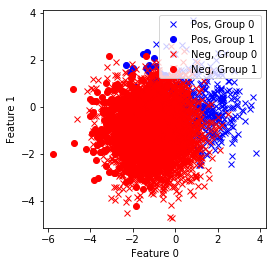

In [21]:
def plot_data(dataset, ax=None):
  # Plot data set.
  features = dataset["features"]
  labels = dataset["labels"]
  groups = dataset["groups"]
  
  # Create axes if not specified
  if not ax:
    _, ax = plt.subplots(1, 1, figsize=(4.0, 4.0))
  ax.set_xlabel("Feature 0")
  ax.set_ylabel("Feature 1")
  
  # Plot positive points in group 0
  data = features[(labels==1) & (groups==0), :]
  ax.plot(data[:,0], data[:,1], 'bx', label="Pos, Group 0")
  
  # Plot positive points in group 1
  data = features[(labels==1) & (groups==1), :]
  ax.plot(data[:,0], data[:,1], 'bo', label="Pos, Group 1")
  
  # Plot negative points in group 0
  data = features[(labels==-1) & (groups==0), :]
  ax.plot(data[:,0], data[:,1], 'rx', label="Neg, Group 0")
  
  # Plot negative points in group 1
  data = features[(labels==-1) & (groups==1), :]
  ax.plot(data[:,0], data[:,1], 'ro', label="Neg, Group 1")
  ax.legend(loc = "upper right")


def plot_model(weights, ax, x_range, y_range, fmt):
  # Plot model decision boundary.
  ax.plot([x_range[0], x_range[1]], 
          [-x_range[0] * weights[0] / weights[1],
           -x_range[1] * weights[0] / weights[1]],
          fmt)
  ax.set_ylim(y_range)
  

# Sample data set.
dataset = create_dataset(num_queries=500, num_docs=10)
plot_data(dataset)

## Evaluation Metrics

We will also need functions to evaluate the pairwise error rates for a linear model.

In [0]:
def get_mask(dataset, pos_group, neg_group=None):
  # Returns a boolean mask selecting positive-negative document pairs where 
  # the protected group for  the positive document is pos_group and 
  # the protected group for the negative document (if specified) is neg_group.
  groups = dataset['groups']
  num_negdocs = dataset['num_negdocs']
  
  # Repeat group membership positive docs as many times as negative docs.
  mask_pos = groups[:,0] == pos_group
  mask_pos_rep = np.repeat(mask_pos.reshape(-1,1), num_negdocs, axis=1)
  
  if neg_group is None:
    return mask_pos_rep
  else:
    mask_neg = groups[:,1:] == neg_group
    return mask_pos_rep & mask_neg


def error_rate(model, dataset):
  # Returns error rate of model on dataset.
  features = dataset["features"]
  num_negdocs = dataset['num_negdocs']
  
  scores = np.matmul(features, model)
  pos_scores_rep = np.repeat(scores[:, 0].reshape(-1,1), num_negdocs, axis=1)
  neg_scores = scores[:, 1:]
  diff = pos_scores_rep - neg_scores
  
  return np.mean(diff.reshape((-1)) <= 0)


def group_error_rate(model, dataset, pos_group, neg_group=None):
  # Returns error rate of model on data set, considering only document pairs, 
  # where the protected group for the positive document is pos_group, and the 
  # protected group for the negative document (if specified) is neg_group.
  features = dataset['features']
  num_negdocs = dataset['num_negdocs']
  
  scores = np.matmul(features, model)
  pos_scores_rep = np.repeat(scores[:, 0].reshape(-1,1), num_negdocs, axis=1)
  neg_scores = scores[:, 1:]
  
  mask = get_mask(dataset, pos_group, neg_group)
  diff = pos_scores_rep - neg_scores
  diff = diff * mask
   
  return np.sum(diff.reshape((-1)) < 0) * 1.0 / np.sum(mask)

## Create Linear Model




We then write a function to create the linear ranking model in Tensorflow.

In [0]:
def group_tensors(predictions, dataset, pos_group, neg_group=None):
  # Returns predictions and labels for document-pairs where the protected group 
  # for the positive document is pos_group, and the protected group for the 
  # negative document (if specified) is neg_group.
  mask = get_mask(dataset, pos_group, neg_group)
  mask = np.reshape(mask, (-1))
  group_labels = lambda: tf.constant(np.ones(np.sum(mask)), dtype=tf.float32)
  group_predictions = lambda: tf.boolean_mask(predictions(), mask)
  return group_predictions, group_labels


def linear_model(dataset):
  # Creates a linear ranking model, and returns a nullary function returning
  # predictions on the dataset, and the model weights.

  # Create variables containing the model parameters.
  weights = tf.Variable(tf.ones(dataset["dimension"], dtype=tf.float32), 
                        name="weights")

  # Create a constant tensor containing the features.
  features_tensor = tf.constant(dataset["features"], dtype=tf.float32)

  # Create a nullary function that returns applies the linear model to the 
  # features and returns the tensor with the predictions.
  def predictions():
    predicted_scores = tf.tensordot(features_tensor, weights, axes=(2, 0))

    # Compute ranking errors and flatten tensor.
    pos_scores = tf.slice(predicted_scores, begin=[0,0], 
                          size=[-1, dataset["num_posdocs"]])
    neg_scores = tf.slice(predicted_scores, begin=[0, dataset["num_posdocs"]], 
                          size=[-1,-1])
    pos_scores_rep = tf.tile(pos_scores, multiples=(1, dataset["num_negdocs"]))
    predictions_tensor = tf.reshape(pos_scores_rep - neg_scores, shape=[-1])

    return predictions_tensor
  
  return predictions, weights

## Formulate Optimization Problem

We are ready to formulate the constrained optimization problem using the TFCO library.

In [0]:
def formulate_problem(dataset, constraint_groups=[], constraint_slack=None):
  # Returns a RateMinimizationProblem object and the linear model weights.
  #
  # Formulates a constrained problem that optimizes the error rate for a linear
  # model on the specified dataset, subject to pairwise fairness constraints 
  # specified by the constraint_groups and the constraint_slack.
  # 
  # Args:
  #   dataset: Dataset dictionary returned by create_dataset()
  #   constraint_groups: List containing tuples of the form 
  #     ((pos_group0, neg_group0), (pos_group1, neg_group1)), specifying the 
  #     group memberships for the document pairs to compare in the constraints.
  #   constraint_slack: slackness "\epsilon" allowed in the constraints.

  # Create linear model: we get back a nullary function returning the 
  # predictions on the dataset, and the model weights.
  predictions, weights = linear_model(dataset)

  # Create a nullary function returning a constant tensor with the labels.
  labels = lambda: tf.constant(np.ones(dataset["tot_pairs"]), dtype=tf.float32)
  
  # Context for the optimization objective.
  context = tfco.rate_context(predictions, labels)
  
  # Constraint set.
  constraint_set = []
  
  # Context for the constraints.
  for ((pos_group0, neg_group0), (pos_group1, neg_group1)) in constraint_groups:
    # Context for group 0.
    group0_predictions, group0_labels = group_tensors(
        predictions, dataset, pos_group0, neg_group0)
    context_group0 = tfco.rate_context(group0_predictions, group0_labels)
    # Context for group 1.
    group1_predictions, group1_labels = group_tensors(
        predictions, dataset, pos_group1, neg_group1)
    context_group1 = tfco.rate_context(group1_predictions, group1_labels)

    # Add constraints to constraint set.
    constraint_set.append(
        tfco.false_negative_rate(context_group0) <= (
            tfco.false_negative_rate(context_group1) + constraint_slack)
    )
    constraint_set.append(
        tfco.false_negative_rate(context_group1) <= (
            tfco.false_negative_rate(context_group0) + constraint_slack)
    )
  
  # Formulate constrained minimization problem.
  problem = tfco.RateMinimizationProblem(
      tfco.error_rate(context), constraint_set)
  
  return problem, weights

## Train Model

The following function then trains the linear model by solving the above constrained optimization problem. We will handle three type of pairwise fairness constraints.

In [0]:
# Pairwise fairness constraint types.
MARGINAL_EQUAL_OPPORTUNITY = 0
CROSS_GROUP_EQUAL_OPPORTUNITY = 1
CROSS_AND_WITHIN_GROUP_EQUAL_OPPORTUNITY = 2

In [0]:
def train_model(train_set, params):
  # Trains the model and returns the trained model weights, objective and 
  # maximum constraint violation values.

  # Set up problem and model.
  if params['flag_constrained']:
    # Constrained optimization.
    if params['constraint_type'] == MARGINAL_EQUAL_OPPORTUNITY:
      constraint_groups = [((0, None), (1, None))]
    elif params['constraint_type'] == CROSS_GROUP_EQUAL_OPPORTUNITY:
      constraint_groups = [((0, 1), (1, 0))]
    else:
      constraint_groups = [((0, 1), (1, 0)), ((0, 0), (1, 1))]
  else:
    # Unconstrained optimization.
    constraint_groups = []

  problem, weights = formulate_problem(
      train_set, constraint_groups, params["constraint_bound"])
  
  # Set up optimization problem.
  optimizer = tfco.ProxyLagrangianOptimizerV2(
      tf.keras.optimizers.Adagrad(learning_rate=params["learning_rate"]),
      num_constraints=problem.num_constraints)
  
  # List of trainable variables.
  var_list = (
      [weights] + problem.trainable_variables + optimizer.trainable_variables())
  
  # List of objectives and constraint violations during course of training.
  objectives = []
  constraints = []

  # Run loops * iterations_per_loop full batch iterations.
  for ii in xrange(params['loops']):
    for ii in xrange(params['iterations_per_loop']):
      optimizer.minimize(problem, var_list=var_list)
    objectives.append(problem.objective())
    if params['flag_constrained']:
      constraints.append(max(problem.constraints()))

  return weights.numpy(), objectives, constraints

## Summarize and Plot Results

Having trained a model, we will need functions to summarize the various evaluation metrics and plot the trained decision boundary

In [0]:
def evaluate_results(model, test_set, params):
  # Returns overall and group error rates for model on test set.
  if params['constraint_type'] == MARGINAL_EQUAL_OPPORTUNITY:
    return (error_rate(model, test_set),
            [group_error_rate(model, test_set, 0), 
             group_error_rate(model, test_set, 1)])
  else:
    return (error_rate(model, test_set),
            [[group_error_rate(model, test_set, 0, 0),
              group_error_rate(model, test_set, 0, 1)],
             [group_error_rate(model, test_set, 1, 0),
              group_error_rate(model, test_set, 1, 1)]])
    
    
def display_results(model, objectives, constraints, test_set, params, ax):
  # Prints evaluation results for model on test data 
  # and plots its decision boundary
  
  # Evaluate model on test set and print results.
  error, group_error = evaluate_results(model, test_set, params)
  
  if params['constraint_type'] == MARGINAL_EQUAL_OPPORTUNITY:
    if params['flag_constrained']:
      print 'Constrained', '\t \t',
    else:
      print 'Test Error\t \t', 'Overall', '\t', 'Group 0', '\t', 'Group 1', 
      print '\t', 'Diff'
      print 'Unconstrained', '\t \t',
    print("%.3f" % (error_rate(model, test_set)) + '\t\t' +
          "%.3f" % group_error[0] + '\t\t' + "%.3f" % group_error[1] + '\t\t'
          "%.3f" % abs(group_error[0] - group_error[1]))
  elif params['constraint_type'] == CROSS_GROUP_EQUAL_OPPORTUNITY:
    if params['flag_constrained']:
      print 'Constrained', '\t \t',
    else:
      print 'Test Error\t \t', 'Overall', '\t', 'Group 0/1', '\t', 'Group 1/0',
      print '\t', 'Diff'
      print 'Unconstrained', '\t \t',
    print("%.3f" % error + '\t\t' + 
          "%.3f" % group_error[0][1] + '\t\t' +
          "%.3f" % group_error[1][0] + '\t\t' +
          "%.3f" % abs(group_error[0][1] - group_error[1][0]))
  else:
    if params['flag_constrained']:
      print 'Constrained', '\t \t',
    else:
      print 'Test Error\t \t', 'Overall', '\t', 'Group 0/1', '\t', 'Group 1/0',
      print '\t', 'Diff', '\t',
      print '\t', 'Group 0/0', '\t', 'Group 1/1', '\t', 'Diff'
      print 'Unconstrained', '\t \t',
    print("%.3f" % error + '\t\t' + 
          "%.3f" % group_error[0][1] + '\t\t' +
          "%.3f" % group_error[1][0] + '\t\t' +
          "%.3f" % abs(group_error[0][1] - group_error[1][0]) + '\t\t' +
          "%.3f" % group_error[0][0] + '\t\t' +
          "%.3f" % group_error[1][1] + '\t\t' +
          "%.3f" % abs(group_error[0][0] - group_error[1][1]))
  
  # Plot decision boundary and progress of training objective/constraint viol.
  if params['flag_constrained']:
    ax[0].set_title("Model: Constrained")
  else:
    ax[0].set_title("Model: Unconstrained")
  features = train_set['features']
  plot_data(train_set, ax[0])
  plot_model(model, ax[0], 
             [features[:, :, 0].min(), features[:, :, 0].max()], 
             [features[:, :, 1].min(), features[:, :, 1].max()], 
             "k--")
  
  if params['flag_constrained']:
    ax[1].set_title("Objective (Hinge)")
    ax[1].set_xlabel("Number of epochs")
    objective_curve, = ax[1].plot(range(params['loops']), objectives)

    ax[2].set_title("Constraint Violation")
    ax[2].set_xlabel("Number of epochs")
    constraint_curve, = ax[2].plot(range(params['loops']), constraints)

# Experimental Results

We now run experiments with two types of pairwise fairness criteria: (1) marginal equal opportunity and (2) pairwise equal opportunity. In each case, we compare an unconstrained model trained to optimize the error rate and a constrained model trained with pairwise fairness constraints.

## (1) Marginal Equal Opportunity


For a ranking model $f: \mathbb{R}^d \rightarrow \mathbb{R}$, recall:
- $err(f)$ as the pairwise ranking error for model $f$ over all pairs of positive and negative documents
$$
err(f) ~=~ \mathbf{E}\big[\mathbb{I}\big(f(x) < f(x')\big) \,\big|\, y = 1,~ y' = 0\big]
$$

and we additionally define:

- $err_i(f)$ as the row-marginal pairwise error over positive-negative document pairs where the pos. document is from group $i$, and the neg. document is from either groups

$$
err_i(f) = \mathbf{E}\big[\mathbb{I}\big(f(x) < f(x')\big) \,\big|\, y = 1,~ y' = 0,~ grp(x) = i\big]
$$

The constrained optimization problem we solve constraints the row-marginal pairwise errors to be similar:

$$min_f\;err(f)$$

$$\text{s.t.   }\;|err_0(f) - err_1(f)| \leq 0.01$$


Test Error	 	Overall 	Group 0 	Group 1 	Diff
Unconstrained 	 	0.077		0.053		0.257		0.203
Constrained 	 	0.095		0.092		0.113		0.021


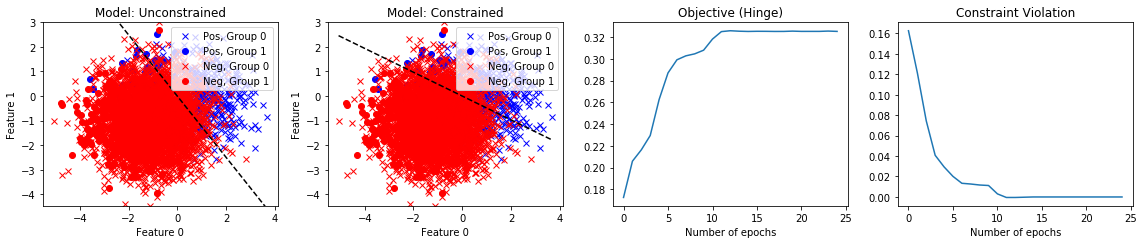

In [28]:
np.random.seed(121212)
train_set = create_dataset(num_queries=500, num_docs=10)
test_set = create_dataset(num_queries=500, num_docs=10)

model_params = {
    'loops': 25, 
    'iterations_per_loop': 10, 
    'learning_rate': 1.0,
    'constraint_type': MARGINAL_EQUAL_OPPORTUNITY, 
    'constraint_bound': 0.01}

# Plot training stats, data and model.
ff, ax = plt.subplots(1, 4, figsize=(16.0, 3.5))

# Unconstrained optimization.
model_params['flag_constrained'] = False
model, objectives, constraints = train_model(train_set, model_params)
display_results(model, objectives, constraints, test_set, model_params, [ax[0]])

# Constrained optimization.
model_params['flag_constrained'] = True
model, objectives, constraints = train_model(train_set, model_params)
display_results(model, objectives, constraints, test_set, model_params, ax[1:])

ff.tight_layout()

## (2) Pairwise Equal Opportunity

Recall that we denote
 $err_{i,j}(f)$ as the ranking error over positive-negative document pairs where the pos. document is from group $i$, and the neg. document is from group $j$.
$$
err_{i, j}(f) ~=~ \mathbf{E}\big[\mathbb{I}\big(f(x) < f(x')\big) \,\big|\, y = 1,~ y' = 0,~ grp(x) = i, ~grp(x') = j\big]
$$


We first constrain only the cross-group errors, highlighted below.

<br>
<table border="1" bordercolor="black">
  <tr >
     <td bgcolor="white"> </td>
     <td bgcolor="white"> </td>
     <td bgcolor="white"  colspan=2 align=center><b>Negative</b></td>
  </tr>
  <tr>
    <td bgcolor="white"></td>
    <td bgcolor="white"></td>
    <td>Group 0</td>
    <td>Group 1</td>
  </tr>
  <tr>
    <td bgcolor="white" rowspan=2><b>Positive</b></td>
    <td bgcolor="white">Group 0</td>
    <td bgcolor="white">$err_{0,0}$</td>
    <td bgcolor="white">$\mathbf{err_{0,1}}$</td>
  </tr>
  <tr>
    <td>Group 1</td>
     <td bgcolor="white">$\mathbf{err_{1,0}}$</td>
      <td bgcolor="white">$err_{1,1}$</td>
  </tr>
</table>
<br>

The optimization problem we solve constraints the cross-group pairwise errors to be similar:

$$min_f\; err(f)$$
$$\text{s.t. }\;\; |err_{0,1}(f) - err_{1,0}(f)| \leq 0.01$$


Test Error	 	Overall 	Group 0/1 	Group 1/0 	Diff
Unconstrained 	 	0.077		0.013		0.277		0.263
Constrained 	 	0.118		0.091		0.097		0.005


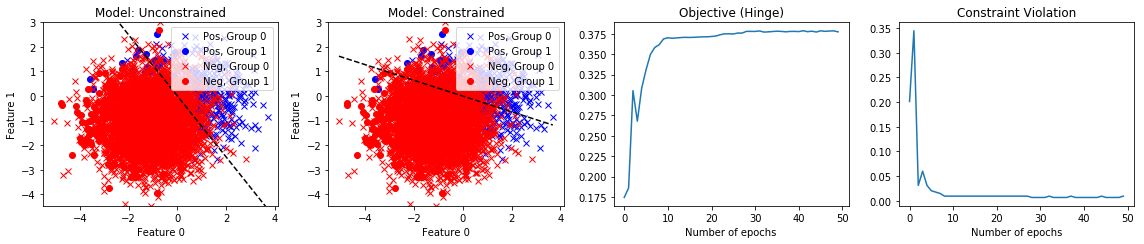

In [29]:
model_params = {
    'loops': 50, 
    'iterations_per_loop': 10, 
    'learning_rate': 1.0, 
    'constraint_type': CROSS_GROUP_EQUAL_OPPORTUNITY, 
    'constraint_bound': 0.01}

# Plot training stats, data and model
ff, ax = plt.subplots(1, 4, figsize=(16.0, 3.5))

model_params['flag_constrained'] = False
model, objectives, constraints = train_model(train_set, model_params)
display_results(model, objectives, constraints, test_set, model_params, [ax[0]])

model_params['flag_constrained'] = True
model, objectives, constraints = train_model(train_set, model_params)
display_results(model, objectives, constraints, test_set, model_params, ax[1:])

ff.tight_layout()

### Cross-group + Within-group Comparisons
We next constrain both the cross-group errors to be similar, and the within-group errors to be similar:
<br>
<table border="1" bordercolor="black">
  <tr >
     <td bgcolor="white"> </td>
     <td bgcolor="white"> </td>
     <td bgcolor="white"  colspan=2 align=center><b>Negative</b></td>
  </tr>
  <tr>
    <td bgcolor="white"></td>
    <td bgcolor="white"></td>
    <td>Group 0</td>
    <td>Group 1</td>
  </tr>
  <tr>
    <td bgcolor="white" rowspan=2><b>Positive</b></td>
    <td bgcolor="white">Group 0</td>
    <td bgcolor="white">$\mathbf{err_{0,0}}$</td>
    <td bgcolor="white">$\mathbf{err_{0,1}}$</td>
  </tr>
  <tr>
    <td>Group 1</td>
     <td bgcolor="white">$\mathbf{err_{1,0}}$</td>
      <td bgcolor="white">$\mathbf{err_{1,1}}$</td>
  </tr>
</table>
<br>

The constrained optimization problem we wish to solve is given by:
$$min_f \;err(f)$$
$$\text{s.t.  }\;\;|err_{0,1}(f) - err_{1,0}(f)| \leq 0.01
\;\;\; |err_{0,0}(f) - err_{1,1}(f)| \leq 0.01
$$

Test Error	 	Overall 	Group 0/1 	Group 1/0 	Diff 		Group 0/0 	Group 1/1 	Diff
Unconstrained 	 	0.077		0.013		0.277		0.263		0.057		0.089		0.032
Constrained 	 	0.099		0.054		0.116		0.062		0.103		0.054		0.049


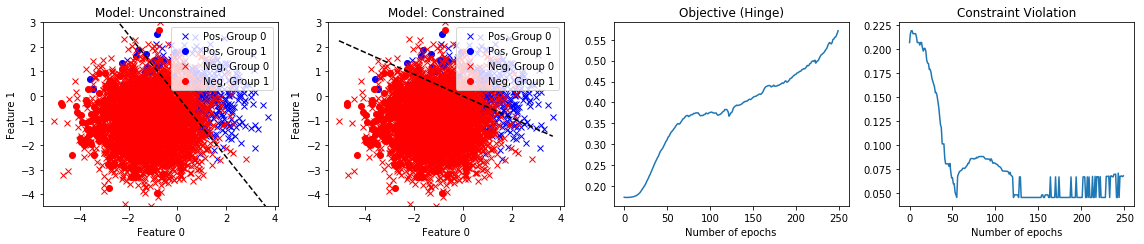

In [30]:
model_params = {
    'loops': 250, 
    'iterations_per_loop': 10, 
    'learning_rate': 0.2, 
    'constraint_type': CROSS_AND_WITHIN_GROUP_EQUAL_OPPORTUNITY, 
    'constraint_bound': 0.01
}

# Plot training stats, data and model
ff, ax = plt.subplots(1, 4, figsize=(16.0, 3.5))

model_params['flag_constrained'] = False
model, objectives, constraints = train_model(train_set, model_params)
display_results(model, objectives, constraints, test_set, model_params, [ax[0]])

model_params['flag_constrained'] = True
model, objectives, constraints = train_model(train_set, model_params)
display_results(model, objectives, constraints, test_set, model_params, ax[1:])

ff.tight_layout()

### Conclusion
The experimental results show that unconstrained training performs poorly on the pairwise fairness metrics, while the constrained optimization methods perform yield significantly lower fairness violations at the cost of a higher overall error rate. The constrained model ends up substatially lowering the error rates associated with the minorty group (group 1), at the cost of a slightly higher error rate for the majority group (group 0).

Also, note that the quality of the learned ranking function depends on the slope of the hyperplane and is unaffected by its intercept. The hyperplane learned by the unconstrained approach ranks the majority examples (the group marked with x) well, but is not accurate at ranking the minority examples (the group marked with o). 